In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from trainer import Trainer
from option import build_option
from utils.loss_utils import compute_embedding_loss, compute_normal_loss, \
        compute_param_loss, compute_nnl_loss, compute_miou, compute_type_miou_abc
from utils.main_utils import npy
from utils.abc_utils import mean_shift, compute_entropy, construction_affinity_matrix_type, \
        construction_affinity_matrix_normal
import scipy.stats as stats
import sys; sys.argv=['']
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import numpy as np
import h5py

import pandas as pd


In [2]:
class args:
    SEED = 124654
    IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256

    RESOLUTION_3D = 0.03125
    SUBSAMPLE_FACTOR = 40
    POINTS_VISUAIZATION_STEP = SUBSAMPLE_FACTOR
    SAMPLING = 'random'

In [3]:
def pca_numpy(X):
    S, U = np.linalg.eig(X.T @ X)
    return S, U

def rotation_matrix_a_to_b(A, B):
    """
    Finds rotation matrix from vector A in 3d to vector B
    in 3d.
    B = R @ A
    """
    cos = np.dot(A, B)
    sin = np.linalg.norm(np.cross(B, A))
    u = A
    v = B - np.dot(A, B) * A
    v = v / (np.linalg.norm(v) + EPS)
    w = np.cross(B, A)
    w = w / (np.linalg.norm(w) + EPS)
    F = np.stack([u, v, w], 1)
    G = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]])
    # B = R @ A
    try:
        R = F @ G @ np.linalg.inv(F)
    except:
        R = np.eye(3, dtype=np.float32)
    return R

In [4]:
class MyTrainer(Trainer):
    def test_our_abc(self, points, normals, postprocess=True):
        if len(points.shape)==2:
            points = points.unsqueeze(dim=0)
            normals=normals.unsqueeze(dim=0)
        inputs_xyz_th = points.float().cuda().permute(0,2,1)
        inputs_n_th = normals.float().cuda().permute(0,2,1)
        if self.opt.input_normal:
            affinity_feat, type_per_point, normal_per_point, param_per_point, sub_idx = self.model(inputs_xyz_th, inputs_n_th, postprocess=postprocess)
        else:
            affinity_feat, type_per_point, param_per_point, sub_idx = self.model(inputs_xyz_th, inputs_n_th, postprocess=postprocess)
           
        inputs_xyz_sub = torch.gather(inputs_xyz_th, -1, sub_idx.unsqueeze(1).repeat(1,3,1))
        N_gt = normals.float().cuda()
        N_gt = torch.gather(N_gt, 1, sub_idx.unsqueeze(-1).repeat(1,1,3))

        loss_dict = {}
        
        if 'n' in self.opt.loss_class:
            normal_loss = compute_normal_loss(normal_per_point, N_gt)
            loss_dict['normal_loss'] = self.opt.normal_weight * normal_loss
        total_loss = 0
        for key in loss_dict:
            if 'loss' in key:
                total_loss += loss_dict[key]

        if postprocess:
                
            affinity_matrix = construction_affinity_matrix_type(inputs_xyz_sub, type_per_point, param_per_point, self.opt.sigma)
           
            affinity_matrix_normal = construction_affinity_matrix_normal(inputs_xyz_sub, N_gt, sigma=self.opt.normal_sigma, knn=self.opt.edge_knn) 

             
            spec_embedding_list = []
            weight_ent = []

            # use network feature
            feat_ent = self.opt.feat_ent_weight - float(npy(compute_entropy(affinity_feat)))
            weight_ent.append(feat_ent)
            spec_embedding_list.append(affinity_feat)
            
            # use geometry distance feature
            topk = self.opt.topK            
            e, v = torch.lobpcg(affinity_matrix, k=topk, niter=10)
            v = v / (torch.norm(v, dim=-1, keepdim=True) + 1e-16)

            dis_ent = self.opt.dis_ent_weight - float(npy(compute_entropy(v)))
            
            weight_ent.append(dis_ent)
            spec_embedding_list.append(v)
             
            # use edge feature
            edge_topk = self.opt.edge_topK
            e, v = torch.lobpcg(affinity_matrix_normal, k=edge_topk, niter=10)
            v = v / (torch.norm(v, dim=-1, keepdim=True) + 1e-16)
            
            edge_ent = self.opt.edge_ent_weight - float(npy(compute_entropy(v)))
           
            weight_ent.append(edge_ent)
            spec_embedding_list.append(v)
          
            # combine features
            weighted_list = []
            norm_weight_ent = weight_ent / np.linalg.norm(weight_ent)
            for i in range(len(spec_embedding_list)):
                weighted_list.append(spec_embedding_list[i] * weight_ent[i])

            spectral_embedding = torch.cat(weighted_list, dim=-1)
            
            print("begin mean shift")
            
            spec_cluster_pred = mean_shift(spectral_embedding, bandwidth=self.opt.bandwidth)
            cluster_pred = spec_cluster_pred
 
        return inputs_xyz_sub, cluster_pred, total_loss, loss_dict
    

In [5]:
points = np.load("1_points.txt")
normals = np.load("1_normals.txt")

In [6]:
gt_points = torch.tensor(points).unsqueeze(dim=0).numpy()
means = np.mean(gt_points, 1)
means = np.expand_dims(means, 1)
new_gt_points = (gt_points - means)
EPS =1e-7
P = new_gt_points[0]

# align
S, U = pca_numpy(P)
smallest_ev = U[:, np.argmin(S)]
R = rotation_matrix_a_to_b(smallest_ev, np.array([1, 0, 0]))
# rotate input points such that the minor principal
# axis aligns with x axis.
P = (R @ P.T).T

# normalize
std = np.max(P, 0) - np.min(P, 0)
P = P / (np.max(std) + EPS)

normal_gt = normals
normal_gt = (R @ normal_gt.T).T


In [7]:
points=P
normals=normal_gt

In [8]:
FLAGS = build_option()
FLAGS.data_path = "/projects/grail/jamesn8nb/dataset_archives/ABC_final"
trainer = MyTrainer(FLAGS)
trainer.CHECKPOINT_PATH = "./log/pretrained_models/abc_normal.tar"
trainer.load_checkpoint()
trainer.model.eval()

log to ./log/test
parameters number: 1.389475  M



WARNING - 2023-04-12 22:56:27,516 - module_wrapper - From /projects/grail/jamesn8/projects/Shape/HPNet/utils/tf_logger.py:15: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



PrimitiveNet(
  (affinitynet): PrimitivesEmbeddingDGCNGn(
    (encoder): DGCNNEncoderGn(
      (bn1): GroupNorm(2, 64, eps=1e-05, affine=True)
      (bn2): GroupNorm(2, 64, eps=1e-05, affine=True)
      (bn3): GroupNorm(2, 128, eps=1e-05, affine=True)
      (bn4): GroupNorm(4, 256, eps=1e-05, affine=True)
      (bn5): GroupNorm(8, 1024, eps=1e-05, affine=True)
      (conv1): Sequential(
        (0): Conv2d(12, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(2, 64, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(2, 64, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (conv3): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GroupNorm(2, 128, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (mlp1)

In [9]:
import time
subsample_rate = 7000

In [10]:
if args.SAMPLING:
    if  subsample_rate > 0 and  args.SAMPLING=='random':
        print('random sampling')
        sub_idx = np.random.choice(np.arange(len(points)), subsample_rate)
        points = points[sub_idx]
        normals =normals[sub_idx]
    else:
        raise Exception("No other option for sampling") 

random sampling


In [11]:
trainer.opt.input_normal=True
with torch.no_grad():
    inputs_xyz_sub, cluster_pred, total_loss, loss_dict = trainer.test_our_abc(torch.tensor(points),torch.tensor(normals))

begin mean shift


OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-31
OMP: Info #217: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 32 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #288: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #288: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #288: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #288: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #192: KMP_AFFINITY: 2 sockets x 8 cores/socket x 2 threads/core (16 total cores)
OMP: Info #219: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 16 maps to socket 0 core 0 thread 1 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 17 maps to socket 0 core 1 thread 1 
OMP: 

In [15]:
points_sub = inputs_xyz_sub[0].detach().cpu().numpy().T

In [20]:
cluster_ids  = cluster_pred[0].detach().cpu().numpy()

In [31]:
import plotly.graph_objects as go
import plotly

markers = [{'size':2}]

for i in np.unique(cluster_ids):
    if markers is None:
        marker = markers
    elif len(markers) == 1:
        marker = markers[0]
    else:
        marker = markers[i]
    pnt = points_sub[cluster_ids==i]
    if i == 0:
        fig = go.Figure(data=[go.Scatter3d(x=pnt[::,0], y=pnt[::,1], z=pnt[::,2], mode='markers', marker=marker)])
        continue
    fig.add_trace(go.Scatter3d(x=pnt[::,0], y=pnt[::,1], z=pnt[::,2], mode='markers', marker=marker))

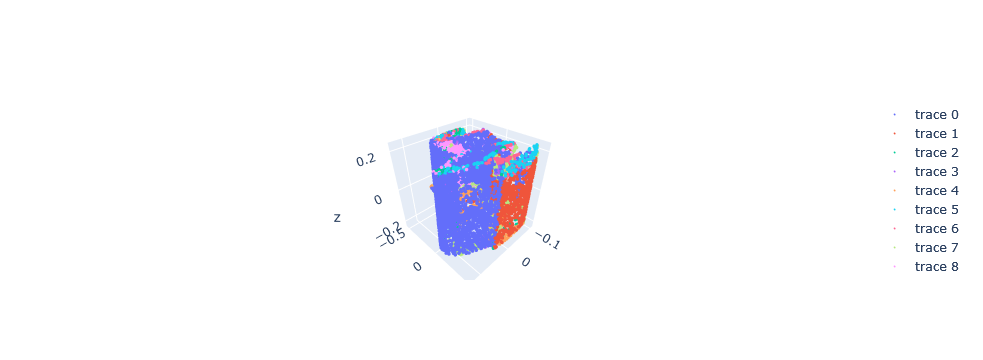

In [32]:
fig.show()